In [1]:
!wget https://raw.githubusercontent.com/ygtxr1997/CelebBasis/main/infer_images/wiki_names.txt

--2023-09-22 19:27:11--  https://raw.githubusercontent.com/ygtxr1997/CelebBasis/main/infer_images/wiki_names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15886 (16K) [text/plain]
Saving to: ‘wiki_names.txt’

wiki_names.txt      100%[===================>]  15.51K  --.-KB/s    in 0s      

2023-09-22 19:27:11 (46.4 MB/s) - ‘wiki_names.txt’ saved [15886/15886]



In [2]:
!wget https://raw.githubusercontent.com/ygtxr1997/CelebBasis/main/infer_images/celebs.txt

--2023-09-22 19:27:16--  https://raw.githubusercontent.com/ygtxr1997/CelebBasis/main/infer_images/celebs.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1528 (1.5K) [text/plain]
Saving to: ‘celebs.txt’

celebs.txt          100%[===================>]   1.49K  --.-KB/s    in 0s      

2023-09-22 19:27:16 (14.3 MB/s) - ‘celebs.txt’ saved [1528/1528]



In [6]:
from pathlib import Path

#with Path('wiki_names.txt').open() as f:
with Path('celebs.txt').open() as f:
    wiki_names = f.read().split('\n')

len(wiki_names) # 1109

first_names = [n for n in set([name.split(' ')[0] for name in wiki_names]) if '.' not in n]
last_names = [n for n in set([name.split(' ')[-1] for name in wiki_names]) if '.' not in n]

len(first_names), len(last_names)

(107, 110)

In [7]:
first_names[:10]

['Brad',
 'Michael',
 'Jerry',
 'Kylie',
 'Britney',
 'Mindy',
 'Elton',
 'Howard',
 'Julia',
 'Roger']

In [8]:
last_names[:10]

['Jade',
 'Morita',
 'Ruhian',
 'Winfrey',
 'McCartney',
 'Cowell',
 'Daheley',
 'Cruise',
 'Jenner',
 'John']

In [9]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionPipeline.from_pretrained(
                model_id,
                revision="fp16",
                #torch_dtype=torch.float16,
                #use_auth_token=True
            ).to('cuda')

safety_checker/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/dmarx/.local/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [62]:
#"diffusers",
#    "EulerDiscreteScheduler"
#pipe.scheduler
import diffusers
#pipe.scheduler = diffusers.EulerDiscreteScheduler()
# https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/blob/main/scheduler/scheduler_config.json
true, false, null = True, False, None
pipe.scheduler = diffusers.EulerDiscreteScheduler(
    **{
      #"_class_name": "EulerDiscreteScheduler",
      #"_diffusers_version": "0.19.0.dev0",
      "beta_end": 0.012,
      "beta_schedule": "scaled_linear",
      "beta_start": 0.00085,
      #"clip_sample": false,
      "interpolation_type": "linear",
      "num_train_timesteps": 1000,
      "prediction_type": "epsilon",
      #"sample_max_value": 1.0,
      #"set_alpha_to_one": false,
      #"skip_prk_steps": true,
      "steps_offset": 1,
      "timestep_spacing": "leading",
      "trained_betas": null,
      "use_karras_sigmas": false
    }
)

In [51]:
diffusers.EulerDiscreteScheduler()

EulerDiscreteScheduler {
  "_class_name": "EulerDiscreteScheduler",
  "_diffusers_version": "0.19.0",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "interpolation_type": "linear",
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "steps_offset": 0,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_karras_sigmas": false
}

In [63]:
kwargs = dict(
    num_inference_steps=25,
    num_images_per_prompt=1,
    
)
prompt = "a painting of an apple"
outv = pipe(prompt, **kwargs)

  0%|          | 0/25 [00:00<?, ?it/s]

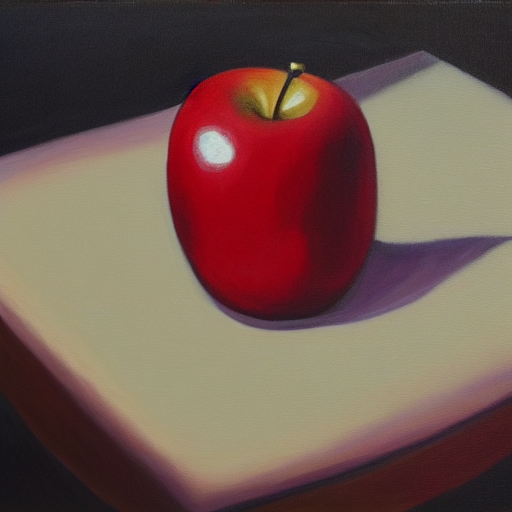

In [64]:
outv.images[0]

In [12]:
# 1. loop over names
# 2. create folder for names
# 3. generate images, save to folder
# 4. compute CLIP/DINO image embeddings, save to folder

# ---

# let's start with 10 names and prototype this procedure generally.
# an important hyper parameter to start with will be the number of images per name.
# let's start by generating an unnecessary number of images for this first group, say 20-100.
# then use these to compute our diversity measures, and calibrate how many images we need by how many images it generally takes to get this measure to converge.


In [23]:
#pipe.requires_safety_checker=False

In [34]:
def passthrough(images, *args, **kargs):
    return images, [False for _ in images]
pipe.safety_checker = passthrough

In [65]:
import time

#names = ["david"] ## TODO: dev
names = first_names

kwargs = dict(
    num_inference_steps=25,
    num_images_per_prompt=8
)

root = Path("images")

images_per_prompt = 24 #40

for name in names:
    #prompt = name
    print(name)
    prompt = f"a photo of {name}, portrait photography, full color, face full frame"
    prompt = prompt.lower().strip()
    
    prompt_clean = prompt.replace(',','')
    outdir = root / prompt_clean.replace(' ','_')  
    outdir.mkdir(parents=True, exist_ok=True)
    while len(list(outdir.glob('*.png'))) < images_per_prompt:
        outv = pipe(prompt, **kwargs)
        if any(outv.nsfw_content_detected):
            #continue
            break

        for idx,im in enumerate(outv.images):
            # would prefer to name images by seed, but hf is makes it hard.
            fname = outdir / f"{int(time.time())}_{idx}.png" 
            im.save(fname)


Brad
Michael
Jerry


  0%|          | 0/25 [00:00<?, ?it/s]

Kylie


  0%|          | 0/25 [00:00<?, ?it/s]

Britney


  0%|          | 0/25 [00:00<?, ?it/s]

Mindy


  0%|          | 0/25 [00:00<?, ?it/s]

Elton


  0%|          | 0/25 [00:00<?, ?it/s]

Howard


  0%|          | 0/25 [00:00<?, ?it/s]

Julia


  0%|          | 0/25 [00:00<?, ?it/s]

Roger


  0%|          | 0/25 [00:00<?, ?it/s]

Johnny


  0%|          | 0/25 [00:00<?, ?it/s]

Dwayne


  0%|          | 0/25 [00:00<?, ?it/s]

Sandra


  0%|          | 0/25 [00:00<?, ?it/s]

Justin


  0%|          | 0/25 [00:00<?, ?it/s]

Paul


  0%|          | 0/25 [00:00<?, ?it/s]

David


  0%|          | 0/25 [00:00<?, ?it/s]

Leonardo


  0%|          | 0/25 [00:00<?, ?it/s]

Kanye


  0%|          | 0/25 [00:00<?, ?it/s]

Dalip


  0%|          | 0/25 [00:00<?, ?it/s]

Bruce


  0%|          | 0/25 [00:00<?, ?it/s]

Devon


  0%|          | 0/25 [00:00<?, ?it/s]

Rush


  0%|          | 0/25 [00:00<?, ?it/s]

Neymar


  0%|          | 0/25 [00:00<?, ?it/s]

Kobe


  0%|          | 0/25 [00:00<?, ?it/s]

Ben


  0%|          | 0/25 [00:00<?, ?it/s]

Hailee


  0%|          | 0/25 [00:00<?, ?it/s]

Lilly


  0%|          | 0/25 [00:00<?, ?it/s]

BD


  0%|          | 0/25 [00:00<?, ?it/s]

Lou


  0%|          | 0/25 [00:00<?, ?it/s]

Nina


  0%|          | 0/25 [00:00<?, ?it/s]

Davood


  0%|          | 0/25 [00:00<?, ?it/s]

Katy


  0%|          | 0/25 [00:00<?, ?it/s]

Ed


  0%|          | 0/25 [00:00<?, ?it/s]

Amita


  0%|          | 0/25 [00:00<?, ?it/s]

Tony


  0%|          | 0/25 [00:00<?, ?it/s]

Rae


  0%|          | 0/25 [00:00<?, ?it/s]

Yayan


  0%|          | 0/25 [00:00<?, ?it/s]

Sarah


  0%|          | 0/25 [00:00<?, ?it/s]

Sung


  0%|          | 0/25 [00:00<?, ?it/s]

Bolo


  0%|          | 0/25 [00:00<?, ?it/s]

Geraldine


  0%|          | 0/25 [00:00<?, ?it/s]

Heung


  0%|          | 0/25 [00:00<?, ?it/s]

Will


  0%|          | 0/25 [00:00<?, ?it/s]

Tyler


  0%|          | 0/25 [00:00<?, ?it/s]

Robin


  0%|          | 0/25 [00:00<?, ?it/s]

Nadia


  0%|          | 0/25 [00:00<?, ?it/s]

Tina


  0%|          | 0/25 [00:00<?, ?it/s]

Meera


  0%|          | 0/25 [00:00<?, ?it/s]

Adele


  0%|          | 0/25 [00:00<?, ?it/s]

Steven


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Cristiano


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Billy


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Brandon


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Dante


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Elon


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Amol


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Drake


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Naga


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Judge


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Konnie


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Harrison


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Angelina


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Lionel


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Tatyana


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Himesh


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

LeBron


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Madonna


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Archie


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Parminder


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Kim


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Dave


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Rihanna


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Ellen


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Robert


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Shaquille


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Jaycee


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Mel


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Yuvraj


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Simon


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Beyoncé


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Kevin


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Mariah


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Celine


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Dennis


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Dev


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Taylor


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Sanjeev


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Iko


  0%|          | 0/25 [00:00<?, ?it/s]

Tom


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Lady


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Kelly


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Rick


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Donnie


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Pat


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

James


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Ernie


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

George


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Brian


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Kunal


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Jennifer


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Anne


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Norah


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Anupam


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Cher


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Keanu


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Celina


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Oprah


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
# let's generate a shit load of images 
# for a few high-bias names as a calibration control
# for sensitivity analysis.

high_bias_names = [
    "oprah",
    "keanu",
    "cher",
    "beyoncé",
    "shaquille",
    "rihanna",
    "anupam",
]

images_per_prompt = 200


for name in high_bias_names:
    #prompt = name
    print(name)
    prompt = f"a photo of {name}, portrait photography, full color, face full frame"
    prompt = prompt.lower().strip()
    
    prompt_clean = prompt.replace(',','')
    outdir = root / prompt_clean.replace(' ','_')  
    outdir.mkdir(parents=True, exist_ok=True)
    while len(list(outdir.glob('*.png'))) < images_per_prompt:
        outv = pipe(prompt, **kwargs)
        if any(outv.nsfw_content_detected):
            #continue
            break

        for idx,im in enumerate(outv.images):
            # would prefer to name images by seed, but hf is makes it hard.
            fname = outdir / f"{int(time.time())}_{idx}.png" 
            im.save(fname)

# TODO

* filtter out images with more than one face in them (check and report on what gets pulled out)
* calibrate # images for experiments
  * "power analysis" - how many images do we need to detect the variance threshold we're interested in?"
* DINOv2 embeddings
* per-prompt (cluster) summary statistics
* tSNE
* separately generate and save input clip emberddings of prompts
* score images relative to centroid in addition to summary statistic for cluster
* repeat procedure across several checkpoints, compare per-cluster summary statistics across checkpoints. expect to observe narrowing of biases as checkpoints are progressively finetuned.

In [ ]:
# DINOv2 embeddings